In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from sklearn.linear_model import LinearRegression as LR

In [2]:
X_simple,t_simple = simple_dataset(noise=10,n_samples=300)

## feature normalisation

# X_simple = X_simple / X_simple.max()

division_ratio = 0.8
split_point =int(division_ratio * len(X_simple)) 

X_train_simple = X_simple[:split_point]
X_test_simple = X_simple[split_point:]

t_train_simple = t_simple[:split_point]
t_test_simple = t_simple[split_point:]


X_complex,t_complex = remodel_complex_dataset()

split_point =int(division_ratio * len(X_complex)) 

X_train_complex = X_complex[:split_point]
X_test_complex = X_complex[split_point:]

t_train_complex = t_complex[:split_point]
t_test_complex = t_complex[split_point:]


X_complex_default,t_complex_default = complex_dataset()
# X_complex_default = np.reshape(X_complex_default,X_complex_default.shape[0])
X_complex_default = X_complex_default[:,np.newaxis]

split_point =int(division_ratio * len(X_complex_default))

X_train_complex_default = X_complex_default[:split_point]
X_test_complex_default = X_complex_default[split_point:]

t_train_complex_default = t_complex_default[:split_point]
t_test_complex_default = t_complex_default[split_point:]


print(X_simple.dtype)

print(X_train_simple.shape)
print(t_train_simple.shape)

print(X_train_complex.shape)
print(t_train_complex.shape)

print(X_test_complex.shape)
print(t_test_complex.shape)

print(X_complex_default.shape,t_complex_default.shape)

float64
(240, 1)
(240,)
(229, 13)
(229,)
(58, 13)
(58,)
(300, 1) (300,)


In [3]:
class LinearRegression(object):

    def __init__(self, learning_rate=0.01, epochs=1000, eps=1e-6):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.eps = eps
        ## [(epoch,error)]
        self.errors = []

    def fit(self, X, t):

        N, D = X.shape
        
        self.w = np.zeros(D)
        prev_w = self.w 
        prev_cost = self.cost(X,t)

        for ep in range(self.epochs):
            g = self.gradient(X,t)
            step = self.learning_rate * g
            self.w = self.w - step
            
            prev_cost = self.cost(X,t)

            self.errors += [(ep,prev_cost)]

            if np.linalg.norm(self.w - prev_w) < self.eps:
                # print("Tolerance broke for: ",self.w,prev_w)
                break

            prev_w = self.w

        # print("Done with all epochs")

        # return self

    def predict(self, X, return_std=False):

        N, D = X.shape

        y = X @ self.w
        # print(X.shape,y.shape,"IN predict")
        
        return y

    
    ## Not 1 / n 
    def cost(self,X,t,return_std=False):
        y = self.predict(X,return_std)
        loss = (y - t) ** 2
        # return 0.5 * loss
        return np.mean(loss)

    def gradient(self,X,t):
        y = self.predict(X)
        # print("In gradient X is: ", X.shape,"T is: ",t.shape,"Y is: ",y.shape," Modified is: ",y.reshape(-1,1).shape )
        d_bias =  -2*sum(t - y)
        # print("D_BIAS:",d_bias)
        d_w = -2*sum(X[:,1:] * (t - y).reshape(-1,1))
        # print("D_W:",d_w,d_w.dtype)
        g = np.append(np.array(d_bias), d_w) 
        return g / X.shape[0] 
        # return g / 2 

In [4]:

class LinearRegressionCompleteForm(object):

    def fit(self, X, t):

        N, D = X.shape
        
        self.w = np.linalg.pinv(X) @ t
        # print(X.shape,t.shape,"IN FIT")
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X, return_std=False):

        N, D = X.shape

        y = X @ self.w
        # print(X.shape,y.shape,"IN predict")
        
        if return_std:

            y_std = np.sqrt(self.var) 

            return y, y_std
        return y

In [5]:
def extract_polynomial_features(X, M):
    phi = X
    return np.array([x ** np.arange(M + 1) for x in phi])

In [6]:
def mean_squared_error(y, t):
    return np.mean((y - t) * (y- t))

def normalised_squared_error(y,t):
    return np.mean((y - t) / t.max()  * (y- t) / t.max())

def RMSE(y,t):
    return np.sqrt(mean_squared_error(y,t))

def NRMSE(y,t):
    return RMSE(y,t) / (np.max(t) - np.min(t))

### On the simple dataset

(240,)
(60,)


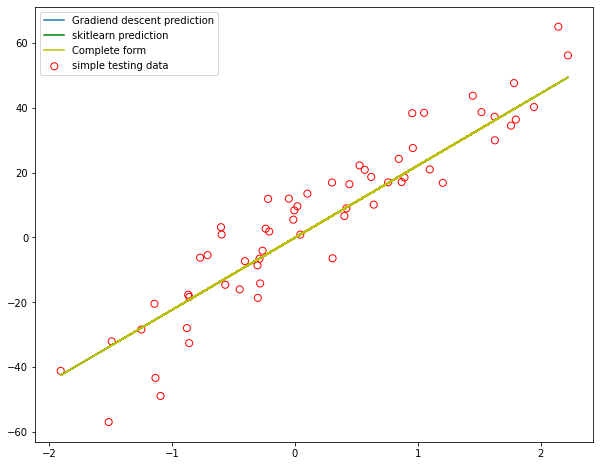

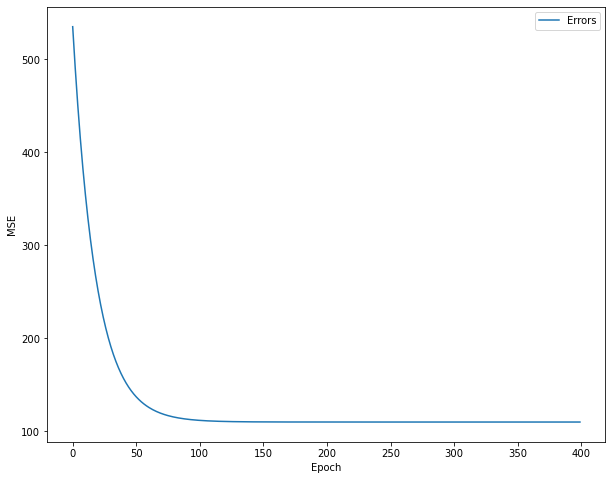

In [7]:
print(t_train_simple.shape)
## merge pana la grad 7 pana da overflow
M = 1

X_train_feat = extract_polynomial_features(X_train_simple,M) 
X_test_feat = extract_polynomial_features(X_test_simple,M)

## needs a different lr for every configuration of simple input set
model = LinearRegression(epochs=400,learning_rate=0.015)
model.fit(X_train_feat,t_train_simple)
y_test = model.predict(X_test_feat)

sk_model = LR()
sk_model.fit(X_train_simple,t_train_simple)

y_test_sk = sk_model.predict(X_test_simple)

complete_model = LinearRegressionCompleteForm()
complete_model.fit(X_train_feat,t_train_simple)

y_test_complete = complete_model.predict(X_test_feat)
print(y_test_complete.shape)
fig = plt.figure(figsize=(10, 8))

plt.scatter(X_test_simple, t_test_simple, facecolor="none", edgecolor="r", s=50, label="simple testing data")
plt.plot(X_test_simple,y_test,label='Gradiend descent prediction')
plt.plot(X_test_simple,y_test_sk,label='skitlearn prediction',color='g')
plt.plot(X_test_simple,y_test_complete,label='Complete form',color='y')
plt.legend()
plt.show()



fig = plt.figure(figsize=(10, 8))
plt.xlabel("Epoch")
plt.ylabel("MSE")
plot_error_x = [ep[0] for ep in model.errors]
plot_error_y = [ep[1] for ep in model.errors]

plt.plot(plot_error_x,plot_error_y,label='Errors')
plt.legend()
plt.show()


### On the complex dataset with feature extraction

(240,)


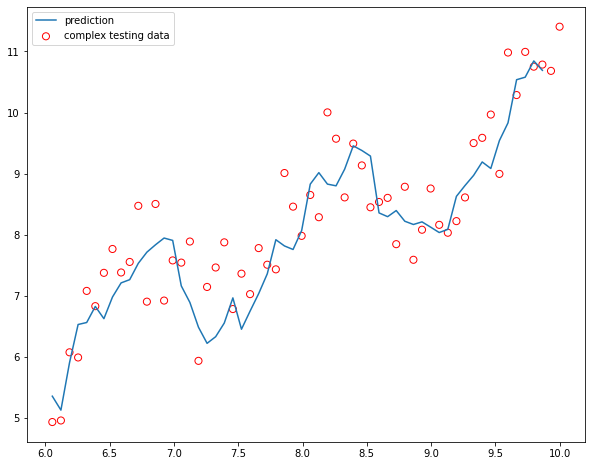

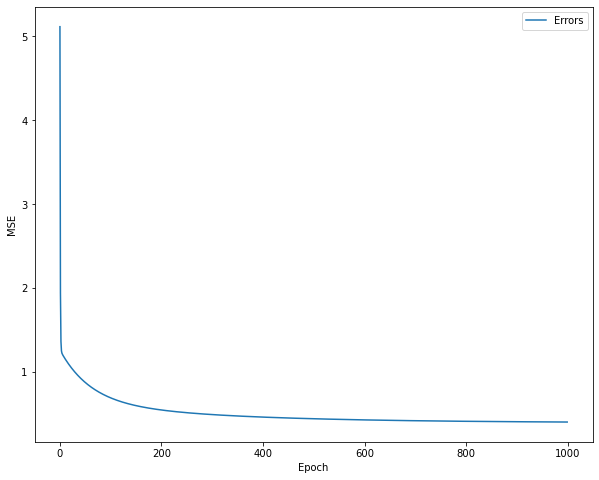

In [8]:
print(t_train_simple.shape)
M = 1

X_train_feat = X_train_complex 
X_test_feat = X_test_complex

model = LinearRegression(learning_rate=0.001)
model.fit(X_train_feat,t_train_complex)
y_test = model.predict(X_test_feat)

fig = plt.figure(figsize=(10, 8))
plt.scatter(X_test_complex_default, t_test_complex_default, facecolor="none", edgecolor="r", s=50, label="complex testing data")
min_len = min(X_test_complex_default.shape[0],y_test.shape[0])
plt.plot(X_test_complex_default[:min_len],y_test[:min_len],label='prediction')
plt.legend()
plt.show()


fig = plt.figure(figsize=(10, 8))
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.plot([ep[0] for ep in model.errors],[ep[1] for ep in model.errors],label='Errors')
plt.legend()
plt.show()

### Linear regression with gradient descent on the complex dataset without feature extraction

(240,)


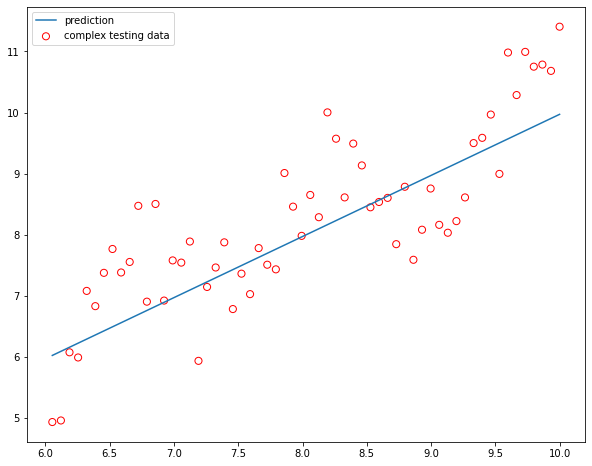

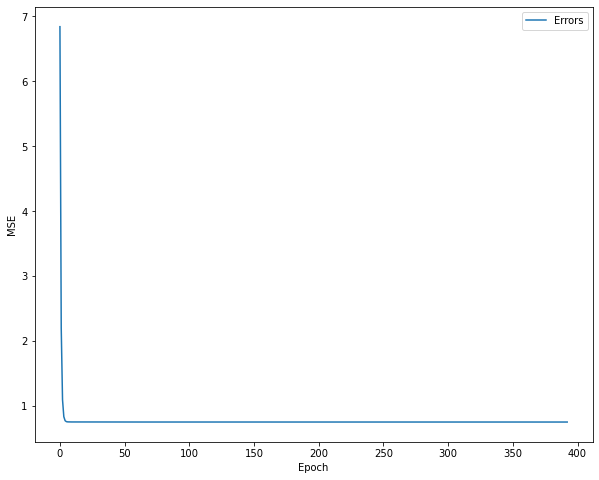

In [9]:
print(t_train_simple.shape)
M = 1

X_train_feat = extract_polynomial_features(X_train_complex_default,M) 
X_test_feat = extract_polynomial_features(X_test_complex_default,M)

model = LinearRegression(learning_rate=0.01)
model.fit(X_train_feat,t_train_complex_default)
y_test = model.predict(X_test_feat)

fig = plt.figure(figsize=(10, 8))
plt.scatter(X_test_complex_default, t_test_complex_default, facecolor="none", edgecolor="r", s=50, label="complex testing data")
min_len = min(X_test_complex_default.shape[0],y_test.shape[0])
plt.plot(X_test_complex_default[:min_len],y_test[:min_len],label='prediction')
plt.legend()
plt.show()


fig = plt.figure(figsize=(10, 8))
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.plot([ep[0] for ep in model.errors],[ep[1] for ep in model.errors],label='Errors')
plt.legend()
plt.show()

### Comparison between the complete form and gradient descent  on the simple dataset 

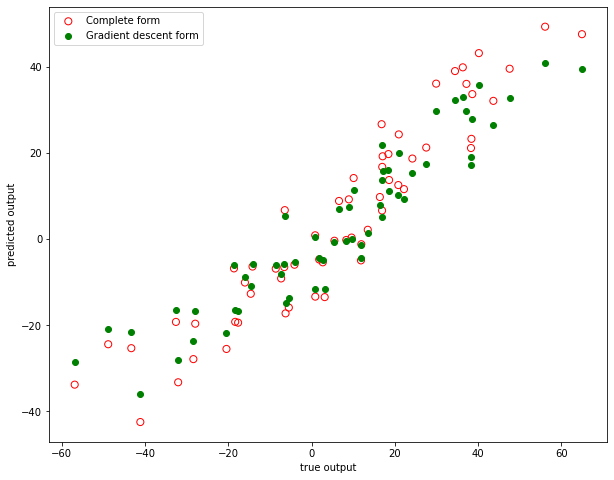

In [10]:
M = 1
X_train_feat = extract_polynomial_features(X_train_simple,M) 
X_test_feat = extract_polynomial_features(X_test_simple,M)

model = LinearRegression(learning_rate=0.001)
model.fit(X_train_feat,t_train_simple)
y_test = model.predict(X_test_feat)

fig = plt.figure(figsize=(10, 8))
plt.xlabel("true output")
plt.ylabel("predicted output")
plt.scatter(t_test_simple,y_test_complete,label='Complete form',facecolor="none", edgecolor="r", s=50)
plt.scatter(t_test_simple,y_test,label='Gradient descent form',color='g')
plt.legend()
plt.show()

### Gradient descent learning rate analysis 

Min no of epochs: 10
Max no of epochs: 1000


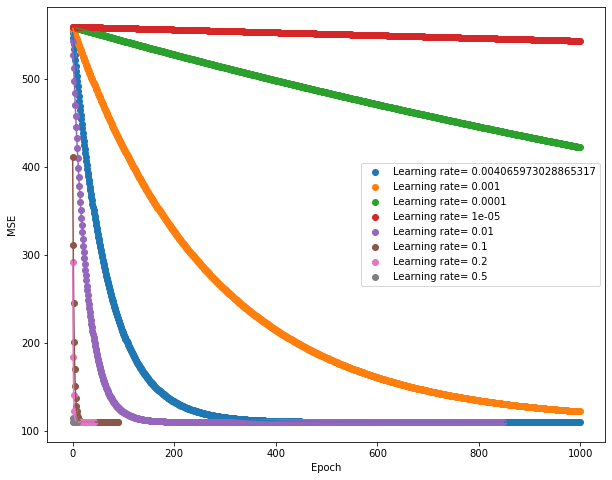

In [11]:
dict_lr = {}
X_train_feat = extract_polynomial_features(X_train_simple,1) 
X_test_feat = extract_polynomial_features(X_test_simple,1)

## nu stiu daca trebuie X_feat @ X_feat.T sau X normal

w,v = np.linalg.eigh(X_train_feat.T @ X_train_feat)
eigen_lr = 1.0 / w.max()

lrs = [eigen_lr,0.001,0.0001,1.00e-5]
not_convergin_lrs = [1.00e-3,1.00e-2,1.00e-1,0.2,0.5]

lrs += not_convergin_lrs

for _lr in lrs:
    model = LinearRegression(learning_rate=_lr,eps=1e-7)
    model.fit(X_train_feat,t_train_simple)
    y = model.predict(X_test_feat)
    dict_lr[_lr] = model.errors




## some reach tolerance before others
## other option is to pad with 0 to the max epoch number
min_no_epochs = min([len(err) for err in dict_lr.values()])
max_no_epochs = max([len(err) for err in dict_lr.values()])
print("Min no of epochs:",min_no_epochs)
print("Max no of epochs:",max_no_epochs)

MAX_NO_EPOCHS = 1000

min_no_epochs = min([len(err) for err in dict_lr.values()])
max_no_epochs = max([len(err) for err in dict_lr.values()])

fig = plt.figure(figsize=(10, 8))
plt.xlabel("Epoch")
plt.ylabel("MSE")

for _lr in dict_lr:
    err = dict_lr[_lr]
    plot_error_x = [ep[0] for ep in err if ep[0] <= 1000]
    plot_error_y = [ep[1] for ep in err if ep[0] <= 1000]
    plt.scatter(plot_error_x,plot_error_y,label="Learning rate= " + str(_lr))
    plt.plot(plot_error_x,plot_error_y)

plt.legend()
plt.show()

#### Se observa ca pentru un learning step foarte mic (1e-5), algoritmul abia incepe sa convearga in 1000 de epoci. Pentru lr = max(eiegenvalue) algoritmul ajunge la convergenta in 400 de epoci. Cele mai bune rezultate se obtin pentru un lr mare (0.2, 0.1, 0.5) pe acest dataset.

## Mini Batch Gradient Descent

In [12]:
class LinearRegressionMB(object):

    def __init__(self, learning_rate=0.01, epochs=1000, eps=1e-6):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.eps = eps
        ## [(epoch,error)]
        self.errors = []
        self.batch_errors = [(0,10)]

    def fit(self, X, t,batch_size=32,reshuffle=False):

        N, D = X.shape
        new_t = t[:,np.newaxis]
        
        self.w = np.zeros(D)
        prev_w = self.w 
        prev_cost = self.cost(X,t)

        if not reshuffle:
            mini_batches = self.create_mini_batches(X, new_t, batch_size)
        for ep in range(self.epochs):
            if reshuffle:
                mini_batches = self.create_mini_batches(X, new_t, batch_size)
                
            for mini_batch in mini_batches:
                X_mini, t_mini = mini_batch

                t_mini = t_mini[:,0]
                
                # print(X_mini.shape)
                if X_mini.shape[0] == 0:
                    # print(X_mini)
                    continue
                
                g = self.gradient(X_mini,t_mini)
                step = self.learning_rate * g
                self.w = self.w - step

                ## aici pune costu per batch
                
                self.batch_errors += [(self.batch_errors[-1][0] + 1,self.cost(X,t))]

            if np.linalg.norm(self.w - prev_w) < self.eps:
                # print("Tolerance broke for: ",self.w,prev_w)
                break

            prev_w = self.w
            
            prev_cost = self.cost(X,t)
            self.errors += [(ep,prev_cost)]

        # print("Done with all epochs")

        # return self

    def predict(self, X, return_std=False):

        N, D = X.shape

        # print("IN PREDICT",X.shape,self.w.shape)
        y = X @ self.w
        # print(X.shape,y.shape,"IN predict")
        
        return y

    ## https://www.geeksforgeeks.org/ml-mini-batch-gradient-descent-with-python/
    def create_mini_batches(self,X, t, batch_size):
        mini_batches = []
        data = np.hstack((X, t))
        np.random.shuffle(data)
        n_minibatches = data.shape[0] // batch_size
        i = 0

        for i in range(n_minibatches + 1):
            mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
            X_mini = mini_batch[:, :-1]
            Y_mini = mini_batch[:, -1].reshape((-1, 1))
            mini_batches.append((X_mini, Y_mini))
        if data.shape[0] % batch_size != 0:
            mini_batch = data[i * batch_size:data.shape[0]]
            X_mini = mini_batch[:, :-1]
            Y_mini = mini_batch[:, -1].reshape((-1, 1))
            mini_batches.append((X_mini, Y_mini))
        
        return mini_batches
    
    ## Not 1 / n 
    def cost(self,X,t,return_std=False):
        y = self.predict(X,return_std)
        loss = (y - t) ** 2
        # return 0.5 * loss
        return np.mean(loss)

    def gradient(self,X,t):
        y = self.predict(X)
        d_bias =  -2*sum(t - y)
        # print("IN GRADIENT",X[:,1:].shape)
        d_w = -2*sum(X[:,1:] * (t - y).reshape(-1,1))
        g = np.append(np.array(d_bias), d_w) 
        return g / X.shape[0] 
        # return g / 2 

    def plot_epoch_errors(self):
        err = self.errors
        plot_error_x = [ep[0] for ep in err]
        plot_error_y = [ep[1] for ep in err]

        fig = plt.figure(figsize=(10, 8))
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        plt.scatter(plot_error_x,plot_error_y)
        plt.plot(plot_error_x,plot_error_y)
        plt.show()


### MSE vs Epoch

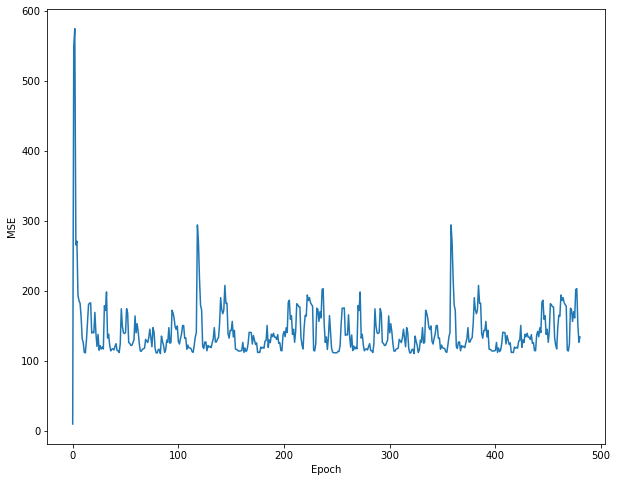

In [13]:
model = LinearRegressionMB(epochs=100,learning_rate=0.1)
M = 1
X_train_feat = extract_polynomial_features(X_train_simple,M) 
X_test_feat = extract_polynomial_features(X_test_simple,M)

model.fit(X_train_feat,t_train_simple,batch_size=1)
y_test = model.predict(X_test_feat)

fig = plt.figure(figsize=(10, 8))
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.plot([i[0] for i in model.batch_errors],[i[1] for i in model.batch_errors])
plt.show()

#### Without reshuffle between epochs

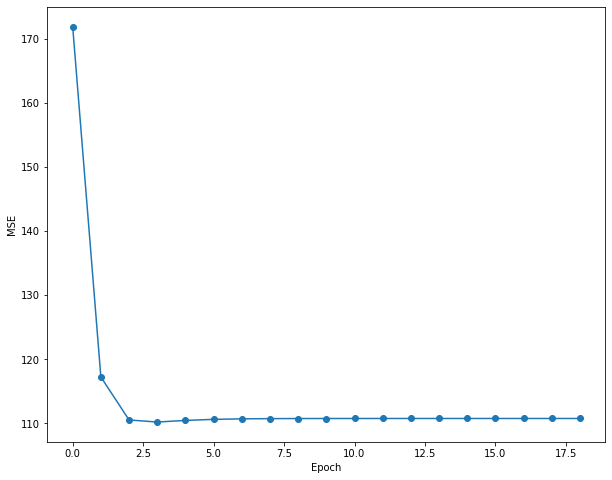

Without reshuffling between epochs


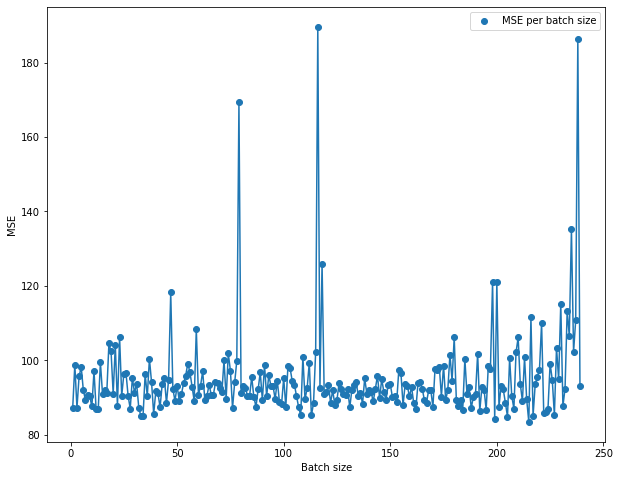

In [14]:
model = LinearRegressionMB(epochs=100,learning_rate=0.05)
M = 1
X_train_feat = extract_polynomial_features(X_train_simple,M) 
X_test_feat = extract_polynomial_features(X_test_simple,M)


batch_dct = {}
batch_sizes = [i for i in range(1,X_train_simple.shape[0])]
for batch_size in batch_sizes:
    if batch_size > X_train_simple.shape[0]:
        continue
    
    model.errors = []    
    model.fit(X_train_feat,t_train_simple,batch_size=batch_size)
    y_test = model.predict(X_test_feat)
    batch_dct[batch_size] = mean_squared_error(y_test,t_test_simple)

    if batch_size == 32:
        model.plot_epoch_errors()


# print(list(batch_dct.keys()),list(batch_dct.values()))

print("Without reshuffling between epochs")
fig = plt.figure(figsize=(10, 8))
plt.xlabel("Batch size")
plt.ylabel("MSE")
plt.plot(list(batch_dct.keys()),list(batch_dct.values()))
plt.scatter(list(batch_dct.keys()),list(batch_dct.values()),label="MSE per batch size")
plt.legend()
plt.show()

## trebuie sa transform la loc mini_batch[][1]



#### With reshuffle between epochs

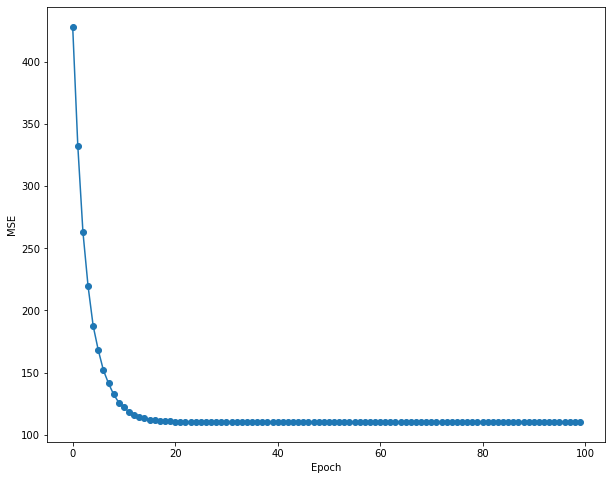

In [15]:
model = LinearRegressionMB(epochs=100)
M = 1
X_train_feat = extract_polynomial_features(X_train_simple,M) 
X_test_feat = extract_polynomial_features(X_test_simple,M)


batch_dct = {}
batch_sizes = [i for i in range(1,X_train_simple.shape[0])]
for batch_size in batch_sizes:
    if batch_size > X_train_simple.shape[0]:
        continue
    
    model.errors = []
    model.fit(X_train_feat,t_train_simple,batch_size=batch_size,reshuffle=True)
    y_test = model.predict(X_test_feat)
    batch_dct[batch_size] = mean_squared_error(y_test,t_test_simple)

    if batch_size == 32:
        model.plot_epoch_errors()

# print(list(batch_dct.keys()),list(batch_dct.values()))

print("Without reshuffling between epochs")
fig = plt.figure(figsize=(10, 8))
plt.xlabel("Batch size")
plt.ylabel("MSE")
plt.plot(list(batch_dct.keys()),list(batch_dct.values()))
plt.scatter(list(batch_dct.keys()),list(batch_dct.values()),label="MSE per batch size")
plt.legend()
plt.show()

## trebuie sa transform la loc mini_batch[][1]

### Stochastic Gradient Descent

In [ ]:
model = LinearRegressionMB(epochs=1000,learning_rate=0.0105)
M = 1
X_train_feat = extract_polynomial_features(X_train_simple,M) 
X_test_feat = extract_polynomial_features(X_test_simple,M)

model.fit(X_train_feat,t_train_simple,batch_size=1,reshuffle=True)
y_test = model.predict(X_test_feat)

sk_model = LR()
sk_model.fit(X_train_simple,t_train_simple)

y_test_sk = sk_model.predict(X_test_simple)


err = model.errors

plot_error_x = [ep[0] for ep in err]
plot_error_y = [ep[1] for ep in err]

fig = plt.figure(figsize=(10, 8))
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.plot(plot_error_x,plot_error_y)
plt.show()

fig = plt.figure(figsize=(10, 8))
plt.scatter(X_test_simple,t_test_simple)
plt.plot(X_test_simple,y_test,label="Stochastic Gradient Descent")
plt.plot(X_test_simple,y_test_sk,label="sklearn")
plt.legend()
plt.show()

## Analiza comparativa

### Complete form

In [ ]:
linear_reg_complete_form = LinearRegressionCompleteForm()
dimensions = 15

errors_simple = []
errors_complex = []

for i in range(1,dimensions + 1):    
    M = i
    X_train_feat = extract_polynomial_features(X_train_simple,M) 
    X_test_feat = extract_polynomial_features(X_test_simple,M)
    
    linear_reg_complete_form.fit(X_train_feat,t_train_simple)

    y_complete = linear_reg_complete_form.predict(X_test_feat)
    errors_simple += [(i,mean_squared_error(y_complete,t_test_simple))]

    ## complex dataset

    X_complex,t_complex = remodel_complex_dataset(points=i)

    split_point =int(division_ratio * len(X_complex)) 

    X_train_complex = X_complex[:split_point]
    X_test_complex = X_complex[split_point:]

    t_train_complex = t_complex[:split_point]
    t_test_complex = t_complex[split_point:]


    X_train_feat = X_train_complex 
    X_test_feat = X_test_complex

    linear_reg_complete_form.fit(X_train_feat,t_train_complex)
    y_complete = linear_reg_complete_form.predict(X_test_feat)
    errors_complex += [(i,mean_squared_error(y_complete,t_test_complex))]



# print(errors_complex)

fig = plt.figure(figsize=(10, 8))
plt.title("Simple dataset")
plt.xlabel("feature no")
plt.ylabel("MSE")
plt.plot([err[0] for err in errors_simple],[err[1] for err in errors_simple])
plt.show()

fig = plt.figure(figsize=(10, 8))
plt.title("Complex dataset")
plt.xlabel("feature no")
plt.ylabel("MSE")
# plt.yscale("log")
plt.plot([err[0] for err in errors_complex],[err[1] for err in errors_complex])
plt.show()

#### Se observa ca pentru forma completa MSE creste cu numarul de dimensiuni pentru ca se face overfit pe setul de antrenare. ( se incearca gasirea unei functii mult prea complexe pentru setul de date)

> Observatie: Graficul de sus reprezinta o analiza folosind functia de extragere de caracteristici exponentiala (X ^ i) pentru setul de date simplu si functia de extragere de caracteristici phi(X,points) = [X_points_1...X_points_points]. Pentru setul de date complex

### Batch gradient descent

In [ ]:
dimensions = 15
no_epochs = 500
learning_rate = 0.000015
linear_reg_batch = LinearRegression(learning_rate=learning_rate,epochs=no_epochs)

converging_lrs = {1: 0.015, 2: 0.015, 3: 0.015, 4: 0.015, 5: 0.0015, 6: 0.00015, 7: 0.00005, 8: 0.00001,9: 0.000001, 10: 0.0000001, 11: 0.00000001
,12: 0.000000001, 13:0.0000000001, 14: 0.00000000001, 15: 0.000000000001}


errors_simple = []
errors_complex = []

for i in range(1,dimensions + 1):    
    linear_reg_batch = LinearRegression(learning_rate=converging_lrs[i],epochs=no_epochs)
    M = i
    X_train_feat = extract_polynomial_features(X_train_simple,M) 
    X_test_feat = extract_polynomial_features(X_test_simple,M)
    
    linear_reg_batch.fit(X_train_feat,t_train_simple)

    y_batch = linear_reg_batch.predict(X_test_feat)
    errors_simple += [(i,mean_squared_error(y_batch,t_test_simple))]

    ## complex dataset

    X_complex,t_complex = remodel_complex_dataset(points=i)

    split_point =int(division_ratio * len(X_complex)) 

    X_train_complex = X_complex[:split_point]
    X_test_complex = X_complex[split_point:]

    t_train_complex = t_complex[:split_point]
    t_test_complex = t_complex[split_point:]


    X_train_feat = X_train_complex 
    X_test_feat = X_test_complex

    linear_reg_batch.fit(X_train_feat,t_train_complex)
    y_complete = linear_reg_batch.predict(X_test_feat)
    common_len = min(y_batch.shape[0],t_test_complex.shape[0])
    errors_complex += [(i,mean_squared_error(y_batch[:common_len],t_test_complex[:common_len]))]

    print("Done with",i)



linear_reg_batch = LinearRegression(learning_rate=0.0015,epochs=no_epochs)

for i in range(dimensions + 1, 34):
    X_complex,t_complex = remodel_complex_dataset(points=i)

    split_point =int(division_ratio * len(X_complex)) 

    X_train_complex = X_complex[:split_point]
    X_test_complex = X_complex[split_point:]

    t_train_complex = t_complex[:split_point]
    t_test_complex = t_complex[split_point:]


    X_train_feat = X_train_complex 
    X_test_feat = X_test_complex

    linear_reg_batch.fit(X_train_feat,t_train_complex)
    ## lucky guess
    y_batch = linear_reg_batch.predict(X_test_feat)
    common_len = min(y_batch.shape[0],t_test_complex.shape[0])
    errors_complex += [(i,mean_squared_error(y_batch[:common_len],t_test_complex[:common_len]))]


print(errors_complex)
print(errors_simple)

errors_complex[-1] = (errors_complex[-1][0],100)

fig = plt.figure(figsize=(10, 8))
plt.title("Simple dataset")
plt.xlabel("feature no")
plt.ylabel("MSE")
plt.plot([err[0] for err in errors_simple],[err[1] for err in errors_simple])
plt.show()

fig = plt.figure(figsize=(10, 8))
plt.title("Complex dataset")
plt.xlabel("feature no")
plt.ylabel("MSE")
# plt.yscale("log")
plt.plot([err[0] for err in errors_complex],[err[1] for err in errors_complex])
plt.show()

#### Se observa ca MSE creste cu numarul de dimensiuni pentru setul simplu de antrenare si in cazul batch gradient descent, fiind un set simplu cu o dependenta liniara incercarea unei functii mai complicate peste duce la overfit si o performanta prosta.

#### In cazul setului de date complex, adaugarea unor noi feature-uri duce la o eroare mai mica. Eroare se stabilizeaza pentru un numar de feature-uri in range-ul 15-30. 

### Minibatch gradient descent

In [ ]:
dimensions = 15
no_epochs = 500
learning_rate = 0.000015
linear_reg_mb = LinearRegressionMB(learning_rate=learning_rate,epochs=no_epochs)

converging_lrs = {1: 0.0015, 2: 0.0015, 3: 0.0015, 4: 0.0015, 5: 0.00015, 6: 0.000015, 7: 0.00000015, 8: 0.00000005,9: 0.000000005, 10: 0.0000000005, 11: 0.00000000005
,12: 0.000000000005, 13:0.0000000000005, 14: 0.00000000000005, 15: 0.000000000000005}


errors_simple = []
errors_complex = []

for i in range(1,dimensions + 1):    
    linear_reg_mb = LinearRegressionMB(learning_rate=converging_lrs[i],epochs=no_epochs)
    M = i
    X_train_feat = extract_polynomial_features(X_train_simple,M) 
    X_test_feat = extract_polynomial_features(X_test_simple,M)
    
    linear_reg_mb.fit(X_train_feat,t_train_simple)

    y_mb = linear_reg_mb.predict(X_test_feat)
    errors_simple += [(i,mean_squared_error(y_mb,t_test_simple))]

    ## complex dataset

    # X_complex,t_complex = remodel_complex_dataset(points=i)

    # split_point =int(division_ratio * len(X_complex)) 

    # X_train_complex = X_complex[:split_point]
    # X_test_complex = X_complex[split_point:]

    # t_train_complex = t_complex[:split_point]
    # t_test_complex = t_complex[split_point:]


    # X_train_feat = X_train_complex 
    # X_test_feat = X_test_complex

    # linear_reg_mb.fit(X_train_feat,t_train_complex)
    # y_mb = linear_reg_mb.predict(X_test_feat)
    # common_len = min(y_mb.shape[0],t_test_complex.shape[0])
    # errors_complex += [(i,mean_squared_error(y_mb[:common_len],t_test_complex[:common_len]))]

    print("Done with",i)



linear_reg_mb = LinearRegressionMB(learning_rate=0.0015,epochs=no_epochs)

for i in range(1, 50):
    X_complex,t_complex = remodel_complex_dataset(points=i)

    split_point =int(division_ratio * len(X_complex)) 

    X_train_complex = X_complex[:split_point]
    X_test_complex = X_complex[split_point:]

    t_train_complex = t_complex[:split_point]
    t_test_complex = t_complex[split_point:]


    X_train_feat = X_train_complex 
    X_test_feat = X_test_complex

    linear_reg_mb.fit(X_train_feat,t_train_complex)
    y_complete = linear_reg_mb.predict(X_test_feat)
    common_len = min(y_batch.shape[0],t_test_complex.shape[0])
    errors_complex += [(i,mean_squared_error(y_batch[:common_len],t_test_complex[:common_len]))]


print(errors_simple)
print(errors_complex)

fig = plt.figure(figsize=(10, 8))
plt.title("Simple dataset")
plt.xlabel("feature no")
plt.ylabel("MSE")
plt.plot([err[0] for err in errors_simple],[err[1] for err in errors_simple])
plt.show()

fig = plt.figure(figsize=(10, 8))
plt.title("Complex dataset")
plt.xlabel("feature no")
plt.ylabel("MSE")
# plt.yscale("log")
plt.plot([err[0] for err in errors_complex],[err[1] for err in errors_complex])
plt.scatter([err[0] for err in errors_complex],[err[1] for err in errors_complex])
plt.show()

### Stochastic gradient descent vs no of features

In [ ]:
dimensions = 15
no_epochs = 500
learning_rate = 0.000015
linear_reg_mb = LinearRegressionMB(learning_rate=learning_rate,epochs=no_epochs)

converging_lrs = {1: 0.0015, 2: 0.0015, 3: 0.0015, 4: 0.0015, 5: 0.00015, 6: 0.000015, 7: 0.00000015, 8: 0.00000005,9: 0.000000005, 10: 0.0000000005, 11: 0.00000000005
,12: 0.000000000005, 13:0.0000000000005, 14: 0.00000000000005, 15: 0.000000000000005}


errors_simple = []
errors_complex = []

for i in range(1,dimensions + 1):    
    linear_reg_mb = LinearRegressionMB(learning_rate=converging_lrs[i],epochs=no_epochs)
    M = i
    X_train_feat = extract_polynomial_features(X_train_simple,M) 
    X_test_feat = extract_polynomial_features(X_test_simple,M)
    
    linear_reg_mb.fit(X_train_feat,t_train_simple,batch_size=1)

    y_mb = linear_reg_mb.predict(X_test_feat)
    errors_simple += [(i,mean_squared_error(y_mb,t_test_simple))]

    ## complex dataset

    # X_complex,t_complex = remodel_complex_dataset(points=i)

    # split_point =int(division_ratio * len(X_complex)) 

    # X_train_complex = X_complex[:split_point]
    # X_test_complex = X_complex[split_point:]

    # t_train_complex = t_complex[:split_point]
    # t_test_complex = t_complex[split_point:]


    # X_train_feat = X_train_complex 
    # X_test_feat = X_test_complex

    # linear_reg_mb.fit(X_train_feat,t_train_complex)
    # y_mb = linear_reg_mb.predict(X_test_feat)
    # common_len = min(y_mb.shape[0],t_test_complex.shape[0])
    # errors_complex += [(i,mean_squared_error(y_mb[:common_len],t_test_complex[:common_len]))]

    print("Done with",i)



linear_reg_mb = LinearRegressionMB(learning_rate=0.00015,epochs=no_epochs)

for i in range(1, 50):
    X_complex,t_complex = remodel_complex_dataset(points=i)

    split_point =int(division_ratio * len(X_complex)) 

    X_train_complex = X_complex[:split_point]
    X_test_complex = X_complex[split_point:]

    t_train_complex = t_complex[:split_point]
    t_test_complex = t_complex[split_point:]


    X_train_feat = X_train_complex 
    X_test_feat = X_test_complex

    linear_reg_mb.fit(X_train_feat,t_train_complex,batch_size=1)
    y_s = linear_reg_mb.predict(X_test_feat)
    common_len = min(y_s.shape[0],t_test_complex.shape[0])
    errors_complex += [(i,mean_squared_error(y_s[:common_len],t_test_complex[:common_len]))]


print(errors_simple)
print(errors_complex)

fig = plt.figure(figsize=(10, 8))
plt.title("Simple dataset")
plt.xlabel("feature no")
plt.ylabel("MSE")
plt.plot([err[0] for err in errors_simple],[err[1] for err in errors_simple])
plt.show()

fig = plt.figure(figsize=(10, 8))
plt.title("Complex dataset")
plt.xlabel("feature no")
plt.ylabel("MSE")
# plt.yscale("log")
plt.plot([err[0] for err in errors_complex],[err[1] for err in errors_complex])
plt.scatter([err[0] for err in errors_complex],[err[1] for err in errors_complex])
plt.show()

### Concluzii

#### Toate cele 4 variante de LR gasesc o solutie buna intr-un numar mic de epoci pe setul de date simplu fara folosirea functiei de extragere caracteristici. Folosirea ei doar creste eroarea, aparand fenomenul de overfit. ( incearca sa se aproximeze o functie foarte complexa care nu generalizeaza bine). Minibatch gradient descent ajunge la convergenta in cel mai mic numar de epoci, dar cu cel mai mare zgomot.

#### Pe setul de date complex se observa ca functia care transforma spatiul obtine cele mai bune rezultate pentru o dimensiune intr 10-20 pentru toate variantele algoritmului. Acelasi fenomen de overfit apare si aici daca dimensiunea e prea mare ( > 50)
